In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

In [2]:
# RONAK'S IMPORTS ##############
import pickle
from joblib import Parallel, delayed
################################

In [3]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [4]:
def honesty_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [5]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
def uncertainty_forests_estimate(X, y, n_estimators = 300, eval_split_size = .33,
                                                  subsample_size = 0.5,
                                                  depth = 30,
                                                  min_samples_leaf = 1):
    """
    Uncertainty forest algorithm for estimating conditional entropy.
    The major steps are as follows:
    1. Split samples into EVAL and TRAIN according to eval_split_size
    2. Get subsample s from TRAIN samples according to subsample_size
    3. Split s into two partitions: STRUCT and PROB
    4. Train decision forest on STRUCT (this is just sklearn's fit function)
    5. For each tree in forest:
        i) Use PROB samples to compute probabilites in each leaf node
        ii) Perform robust finite sampling on posteriors computed by PROB samples
        iii) Use posterior to get probability that eval sample fell in leaf node
        iv) Weight eval sample probabilities by number of samples in leaf node (get class counts)
    6. Compute probabilities from class counts over entire forest
    7. Use probabilities to compute conditional entropies
    8. Return average conditional entropy over all eval samples


    Parameters
    ----------
    X: array-like
        Training samples.

    y: list
        Class labels for training samples.

    n_estimators: int
        Number of trees in forest.

    eval_split_size: float between 0 and 1
        Percent of samples to include in evaluation partition.

    subsample_size: float between 0 and 1
        Percent of non eval samples to use for a tree (subsample forms PROB and STRUCT samples).

    depth: int
        Maximum depth in tree.

    min_samples_leaf
        Minimum number of samples in node to be considered leaf.

    Returns
    -------
    Conditional entropy estimate
    """

    # split samples into eval and non eval
    X_train, X_eval, y_train, _ = train_test_split(X, y, test_size=eval_split_size)

    max_samples = int(X_train.shape[0]*subsample_size)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth,
                              min_samples_leaf = min_samples_leaf,
                              # set default maximum features to sqrt(total features)
                              max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= split_samples,
                              bootstrap = True)

    model.fit(X_train, y_train)
    # Matrix used to compute final estimate
    # Each entry is total number of PROB nodes of class y that fell into
    # the same leaf nodes that a x_eval sample fell into.
    class_counts = np.zeros((X_eval.shape[0], model.n_classes_))
    for tree in model:

        # get total unused samples indices
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), len(X) - split_samples)
        # RONAK EDIT ENDS HERE ##################
        # shuffle unused sample indices
        np.random.shuffle(unsampled_indices)
        # take split_samples amount as PROB indices (honest sampling)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts in tree
        node_counts = tree.tree_.n_node_samples

        # use PROB samples to compute posterior for tree

        # NOTE: this considers probabilities for all nodes in the tree.
        # However, only leaf nodes will have relevant values
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        # for each leaf, count number of samples with each class label that fell into leaf
        # NOTE: unused leaf nodes will have probability 0 for every class

        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1

        # divide each leaf node by number of total samples that fell into leaf node
        row_sums = posterior_class_counts.sum(axis=1)
        # handle divide by 0 errors
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        # perform robust finite sampling
        class_probs = robust_finite_sampling(class_probs, row_sums, model.n_classes_)

        # Get probabilities from EVAL samples for final estimate
        # Weigh the probailities by number of samples in leaf node

        # Get leaf nodes counts for each sample in EVAL
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_eval)])
        # get probability for eval samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
        eval_class_probs = np.array(eval_class_probs)
        # Get total elements
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    forest_probabilities = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(forest_probabilities)*forest_probabilities, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    # return sample mean
    return np.mean(entropies)


def robust_finite_sampling(class_probs, row_sums, n_classes):
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1/(n_classes*row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - (n_classes - 1)/(n_classes*row_sums[elem[0], None])
    return class_probs.tolist()

np.warnings.filterwarnings('ignore')

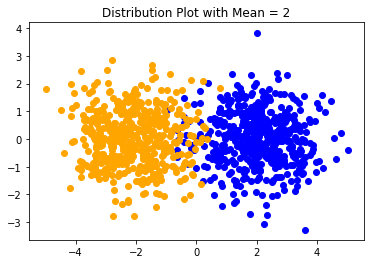

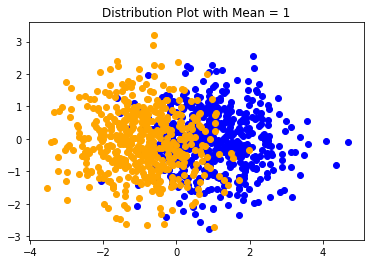

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(1000, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(1000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


In [8]:
def get_cond_entropy_vs_n_parallel_n(mean, d):
    cef = []
    cart = []
    honest = []
    uf = []
    sample_sizes = [i*400 for i in range(1, 16)]
    
    def worker(elem):
        X, y = get_multivariate_sample(elem, d, mean)
        cef_output = cef_estimate(np.array(X), y, 300, .32, depth = 30)
        cart_output = CART_estimate(np.array(X), y, 300, .32, depth = 30)
        honest_output = honesty_estimate(np.array(X), y, 300, .32, depth = 30)
        uf_output = uncertainty_forests_estimate(np.array(X), y)
        
        return (cef_output, cart_output, honest_output, uf_output)
    
    outputs = Parallel(n_jobs=-2)(delayed(worker)(elem) for elem in sample_sizes)
    
    for output in outputs:
        cef.append(output[0])
        cart.append(output[1]) 
        honest.append(output[2]) 
        uf.append(output[3])
        
    return sample_sizes, cef, cart, honest, uf

In [9]:
def get_cond_entropy_vs_n_parallel_trial(mean, d, num_trials, sample_sizes):
    
    cef = np.zeros((len(sample_sizes), num_trials))
    cart = np.zeros((len(sample_sizes), num_trials))
    honest = np.zeros((len(sample_sizes), num_trials))
    uf = np.zeros((len(sample_sizes), num_trials))
    
    def worker(t):
        X, y = get_multivariate_sample(elem, d, mean)
        cef_output = cef_estimate(np.array(X), y, 300, .32, depth = 30)
        cart_output = CART_estimate(np.array(X), y, 300, .32, depth = 30)
        honest_output = honesty_estimate(np.array(X), y, 300, .32, depth = 30)
        uf_output = uncertainty_forests_estimate(np.array(X), y)
        
        return (cef_output, cart_output, honest_output, uf_output)
    
    for i, elem in enumerate(sample_sizes):
        outputs = Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials))
        for t, output in enumerate(outputs):
            cef[i, t] = output[0]
            cart[i, t] = output[1]
            honest[i, t] = output[2] 
            uf[i, t] = output[3]
        
    return sample_sizes, cef, cart, honest, uf

In [11]:
sample_sizes = [i*400 for i in range(1, 16)]
num_trials = 5

sample_sizes, cef, cart, honest, uf = get_cond_entropy_vs_n_parallel_trial(1, 40, num_trials, sample_sizes)

In [ ]:
# sample_sizes, cef, cart, honest, uf = get_cond_entropy_vs_n_parallel(1, 40)

In [ ]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean, d):
    cef = []
    cart = []
    honest = []
    uf = []
    sample_sizes = [i*400 for i in range(1, 16)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        cef.append(cef_estimate(np.array(X), y, 300, .32, depth = 30))
        cart.append(CART_estimate(np.array(X), y, 300, .32, depth = 30))
        honest.append(honesty_estimate(np.array(X), y, 300, .32, depth = 30))
        uf.append(uncertainty_forests_estimate(np.array(X), y))
    return sample_sizes, cef, cart, honest, uf

# sample_sizes, cef, cart, honest, uf = get_cond_entropy_vs_n(1, 40)

In [12]:
reprod_results = {
    'sample_sizes' : sample_sizes, 
    'cef': cef, 
    'cart': cart, 
    'honest': honest, 
    'uf' : uf
}
pickle.dump( reprod_results , open( "reprod_results.pkl", "wb" ) )

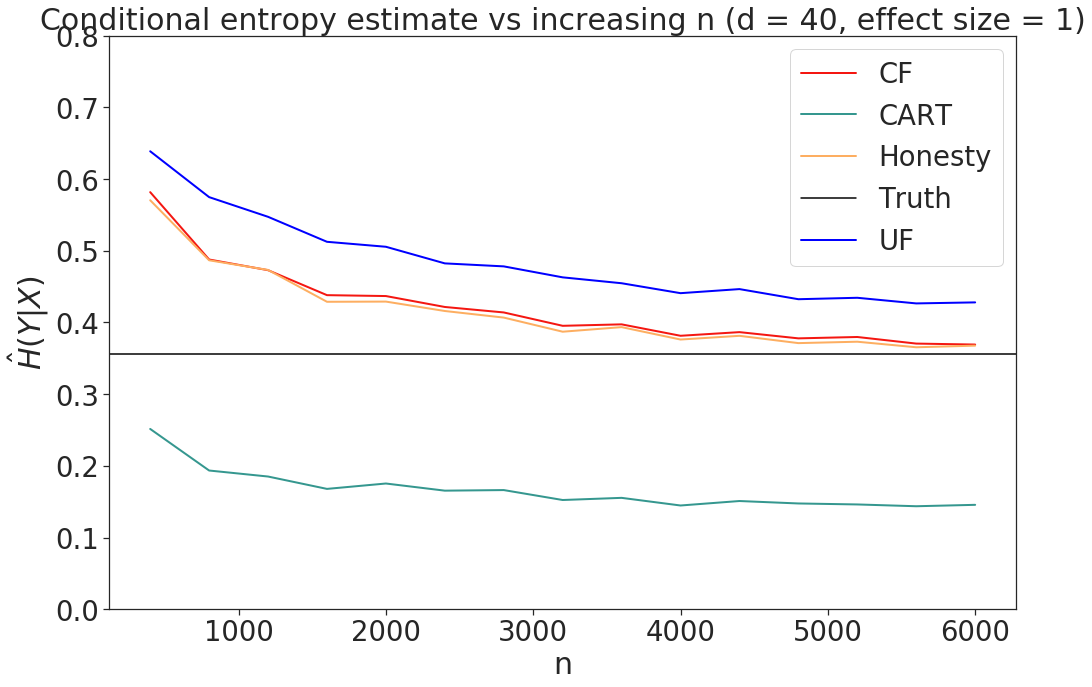

In [14]:
sns.set(font_scale = 2.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

# line_cf, = plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
line_cf, = plt.plot(sample_sizes, np.mean(cef, axis = 1), label = "CF", linewidth = 2, color = "#F41711")

# line_cart, = plt.plot(sample_sizes, cart, label = 'CART', linewidth = 2, color = "#35978f")
line_cart, = plt.plot(sample_sizes, np.mean(cart,axis = 1), label = 'CART', linewidth = 2, color = "#35978f")

# line_honest, = plt.plot(sample_sizes, honest, label = "Honesty", linewidth = 2, color = "#fdae61")
line_honest, = plt.plot(sample_sizes, np.mean(honest,axis = 1), label = "Honesty", linewidth = 2, color = "#fdae61")

# line_uf, = plt.plot(sample_sizes, uf, label = "UF", linewidth=2, color = "blue")
line_uf, = plt.plot(sample_sizes, np.mean(uf,axis = 1), label = "UF", linewidth=2, color = "blue")

line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")

plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cf, line_cart, line_honest, line_true, line_uf])
plt.xlabel('n')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
plt.title("Conditional entropy estimate vs increasing n (d = 40, effect size = 1)")
#plt.savefig("alg_comp_40d_mean0_final_noerror.png")
plt.show()

In [ ]:
sample_sizes, cef, cart, honest, uf = get_cond_entropy_vs_n(1, 1)

sns.set(font_scale = 2.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cf, = plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")

line_cart, = plt.plot(sample_sizes, cart, label = 'CART', linewidth = 2, color = "#35978f")

line_honest, = plt.plot(sample_sizes, honest, label = "Honesty", linewidth = 2, color = "#fdae61")

line_uf, = plt.plot(sample_sizes, uf, label = "UF", linewidth=2, color = "blue")

line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")

plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cf, line_cart, line_honest, line_true, line_uf])
plt.title("Conditional entropy estimate vs increasing n (d = 1, effect size = 1)")
plt.xlabel('n')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
#plt.savefig("alg_comp_40d_mean0_final_noerror.png")
plt.show()

In [ ]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_mean(n, d):
    cef = []
    cart = []
    honest = []
    uf = []
    means = [i*.4 for i in range(1, 16)]
    for elem in tqdm_notebook(means):
        X, y = get_multivariate_sample(n, d, elem)
        cef.append(cef_estimate(np.array(X), y, 300, .32, depth = 30))
        cart.append(CART_estimate(np.array(X), y, 300, .32, depth = 30))
        honest.append(honesty_estimate(np.array(X), y, 300, .32, depth = 30))
        uf.append(uncertainty_forests_estimate(np.array(X), y, 300, .32, depth=30))
    return means, cef, cart, honest, uf
       
means, cef, cart, honest, uf = get_cond_entropy_vs_mean(6000, 1)


In [ ]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import math
from sklearn import mixture

def estimate_p(y):
    return y.count(1)/len(y)

def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy

def truth_1d(mean):
    h_y = -.5*np.log(.5) - .5*np.log(.5)
    h_x_cond_y = normal_entropy(1)*.5 + normal_entropy(1)*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (mean, -mean, 1, 1))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy

In [ ]:
truth = []
for mean in means:
    truth.append(truth_1d(mean))

In [ ]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"

line_cf, = plt.plot(means, cef, label = "CF", linewidth = 4, color = "#F41711")

line_cart, = plt.plot(means, cart, label = 'CART', linewidth = 4, color = "#35978f")

line_honest, = plt.plot(means, honest, label = "Honesty", linewidth = 4, color = "#fdae61")

line_true, = plt.plot(means, truth, label = "Truth", linewidth = 4, color = 'black')
line_uf, = plt.plot(means, uf, label = "UF", linewidth=4, color = "blue")
plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cf, line_cart, line_honest, line_uf, line_true])

plt.title("Conditional entropy vs increasing effect size (d = 1, n = 6000)")
plt.xlabel("Effect Size " + u'(\u03bc)')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
#plt.savefig("alg_comp_40d_n10000_conv0_final_noerror.pdf")
plt.show()

In [ ]:
from tqdm import tqdm_notebook

def get_cond_entropy_vs_mean(n, d):
    cef = []
    cart = []
    honest = []
    uf = []
    means = [i*.4 for i in range(1, 11)]
    for elem in tqdm_notebook(means):
        X, y = get_multivariate_sample(n, d, elem)
        cef.append(cef_estimate(np.array(X), y, 300, .32, depth = 30))
        cart.append(CART_estimate(np.array(X), y, 300, .32, depth = 30))
        honest.append(honesty_estimate(np.array(X), y, 300, .32, depth = 30))
        uf.append(uncertainty_forests_estimate(np.array(X), y, 300, .32, depth=30))
    return means, cef, cart, honest, uf

means, cef, cart, honest, uf = get_cond_entropy_vs_mean(10000, 40)


In [ ]:
truth = []
for mean in means:
    truth.append(truth_1d(mean))

In [ ]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"

line_cf, = plt.plot(means, cef, label = "CF", linewidth = 4, color = "#F41711")

line_cart, = plt.plot(means, cart, label = 'CART', linewidth = 4, color = "#35978f")

line_honest, = plt.plot(means, honest, label = "Honesty", linewidth = 4, color = "#fdae61")

line_true, = plt.plot(means, truth, label = "Truth", linewidth = 4, color = 'black')

line_uf, = plt.plot(means, uf, label = "UF", linewidth=4, color = "blue")

plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cf, line_cart, line_honest, line_uf, line_true])

plt.title("Conditional entropy vs increasing effect size (d = 1, n = 10000)")
plt.xlabel("Effect Size " + u'(\u03bc)')
plt.ylabel("$\hat H(Y|X)$")
plt.tight_layout()
#plt.savefig("alg_comp_40d_n10000_conv0_final_noerror.pdf")
plt.show()